In [67]:
# imports

# dataframes and arrays
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from scipy import stats

# preprocessing and machine learning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

from ctgan import CTGAN

sns.set_theme()

In [2]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# 1. Dataset preparation

Data Dictionary

* customerID: unique identification number for each customer
* Churn: whether the customer has left the company or not
* gender: gender (male and female)
* SeniorCitizen: information about whether a customer is 65 years old or older
* Partner: whether the customer has a partner or not
* Dependents: whether the customer has dependents or not
* tenure: number of months the customer has been under contract
* PhoneService: telephone service subscription
* MultipleLines: subscription to multiple phone lines
* InternetService: subscription to an internet service provider
* OnlineSecurity: additional subscription for online security
* OnlineBackup: additional subscription for online backup
* DeviceProtection: additional subscription for device protection
* TechSupport: additional subscription for technical support, with shorter wait times
* StreamingTV: cable TV subscription
* StreamingMovies: streaming movies subscription
* Contract: type of contract
* PaperlessBilling: whether the customer prefers to receive the bill online
* PaymentMethod: payment method
* Charges.Monthly: total charges for all customer services per month
* Charges.Total: total amount spent by the customer

Link to obtain the data: https://raw.githubusercontent.com/sthemonica/alura-voz/main/Dados/Telco-Customer-Churn.json

In [3]:
# reading json
df = pd.read_json('https://raw.githubusercontent.com/sthemonica/alura-voz/main/Dados/Telco-Customer-Churn.json')

In [4]:
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [5]:
# informações gerais do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 397.4+ KB


**Processing columns in JSON format and generating a dataframe.**

The columns customer, phone, internet, account have their data stored in dictionaries. Since we want to use this data in our dataframe, we need to extract these dictionaries from these columns.

In [6]:
customer_df = pd.DataFrame(df['customer'].values.tolist())
phone_df = pd.DataFrame(df['phone'].values.tolist())
internet_df = pd.DataFrame(df['internet'].values.tolist())
account_df = pd.DataFrame(df['account'].values.tolist())

# getting data from column Charges
charges_df = pd.DataFrame(account_df['Charges'].values.tolist())
charges_df = charges_df.rename(columns={'Monthly': 'MonthlyCharges', 'Total': 'TotalCharges'})

account_df = account_df.drop('Charges', axis=1)

df = pd.concat([df[['customerID', 'Churn']], customer_df, phone_df, internet_df, account_df, charges_df], axis=1)

In [7]:
df.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [8]:
df['SeniorCitizen'] = df['SeniorCitizen'].apply(lambda x: "Yes" if x == 1 else "No")

In [9]:
df.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0002-ORFBO,No,Female,No,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,No,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,No,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,Yes,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,Yes,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [10]:
# changing TotalCharges to float
df['TotalCharges'] = df['TotalCharges'].apply(lambda x: "0" if (x == ' ') or (x == '') else x).astype(float)

**Calculation of a column with daily charges.**

Let's create a new column with daily billing information for the accounts. This can be done simply by dividing the value in the monthly billing column by 30 (standard number of days in a month).

In [11]:
df['DailyCharges'] = df['MonthlyCharges']/30

In [12]:
df.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,DailyCharges
0,0002-ORFBO,No,Female,No,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,No,Male,No,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,Yes,Male,No,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,Yes,Male,Yes,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,Yes,Female,Yes,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.796667


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7267 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   object 
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 non-null   object 
 17  

# 2. Variables analysis

## 2.1. Missing data

Let's check for empty data in our columns. 

Additionally, we need to examine the values appearing in these columns to ensure the integrity of the dataframe.

<Axes: >

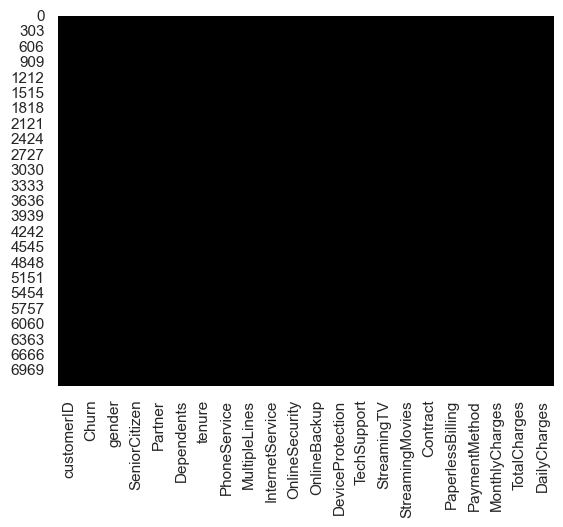

In [14]:
sns.heatmap(df.isna(), cmap='binary_r', cbar=False)

We have confirmed that there are no empty (NaN) values in our dataframe.

However, are all the data present as they should be? Let's verify.

In [13]:
df['Churn'].value_counts()

No     5174
Yes    1869
        224
Name: Churn, dtype: int64

We can see that there are empty strings in the Churn column. Let's replace these values with None (empty data) to facilitate their removal.

Note: Ideally, we would need to identify the reason why this column has empty strings.

In [14]:
df['Churn'] = df['Churn'].apply(lambda x: x if (x == "Yes") or (x == "No") else None)

In [15]:
df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

The Churn column now has 224 missing values after replacing the empty strings with None. We can proceed to remove those rows with null values.

In [16]:
df = df.dropna()
df

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,DailyCharges
0,0002-ORFBO,No,Female,No,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.60,593.30,2.186667
1,0003-MKNFE,No,Male,No,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.90,542.40,1.996667
2,0004-TLHLJ,Yes,Male,No,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.90,280.85,2.463333
3,0011-IGKFF,Yes,Male,Yes,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.00,1237.85,3.266667
4,0013-EXCHZ,Yes,Female,Yes,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.90,267.40,2.796667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,9987-LUTYD,No,Female,No,No,No,13,Yes,No,DSL,...,No,Yes,No,No,One year,No,Mailed check,55.15,742.90,1.838333
7263,9992-RRAMN,Yes,Male,No,Yes,No,22,Yes,Yes,Fiber optic,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,85.10,1873.70,2.836667
7264,9992-UJOEL,No,Male,No,No,No,2,Yes,No,DSL,...,No,No,No,No,Month-to-month,Yes,Mailed check,50.30,92.75,1.676667
7265,9993-LHIEB,No,Male,No,Yes,Yes,67,Yes,No,DSL,...,Yes,Yes,No,Yes,Two year,No,Mailed check,67.85,4627.65,2.261667


## 2.2. Target variable (Churn) analysis

Analysis of the Churn quantity by variable.

In [17]:
obj_cols = np.array(df.select_dtypes('object').columns[2:])
cols_arr = obj_cols.reshape(4, 4)

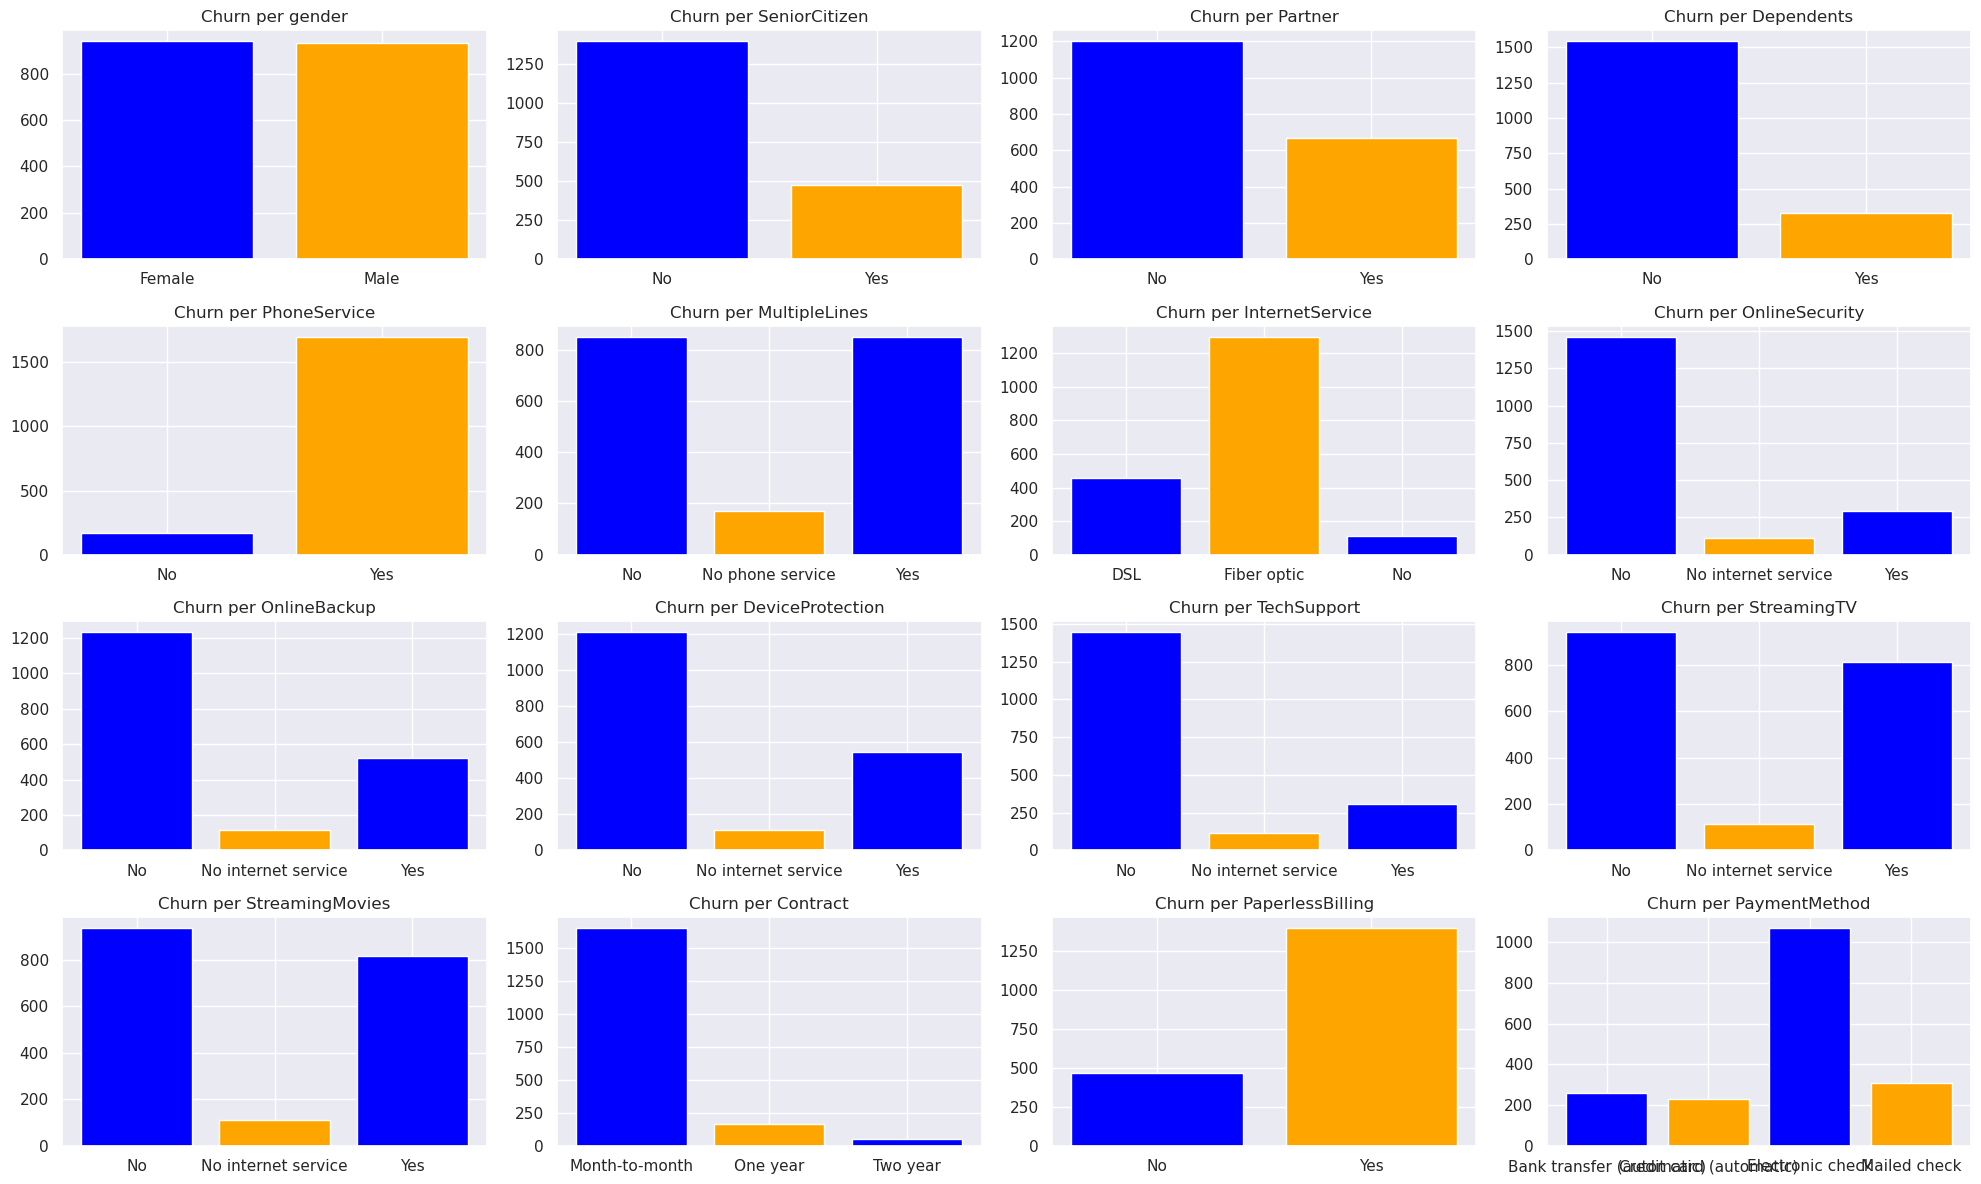

In [18]:
df_aux = df.copy()
df_aux['Churn'] = df_aux['Churn'].apply(lambda x: 0 if x == 'No' else 1)

fig, ax = plt.subplots(cols_arr.shape[0], cols_arr.shape[1], figsize = (20, 12))

for i in range(cols_arr.shape[0]):
    for j in range(cols_arr.shape[1]):
        df_churn_col = df_aux.groupby(cols_arr[i, j], as_index=False).agg({'Churn': 'sum'})
        ax[i, j].bar(x=cols_arr[i, j], height='Churn',
                     data=df_churn_col,
                     color=['blue', 'orange'])
        ax[i, j].set_title(f"Churn per {cols_arr[i, j]}")

plt.tight_layout()

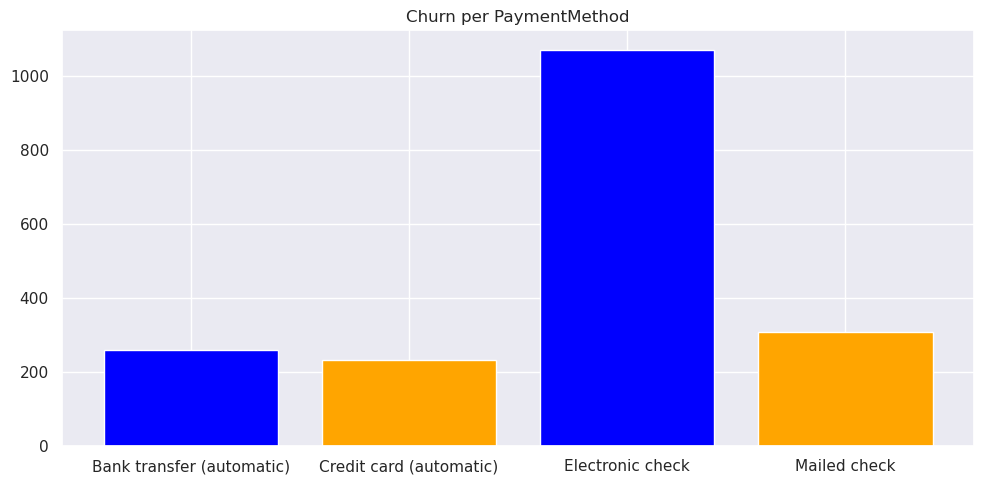

In [19]:
df_aux = df.copy()
df_aux['Churn'] = df_aux['Churn'].apply(lambda x: 0 if x == 'No' else 1)
df_churn_PaymentMethod = df_aux.groupby('PaymentMethod', as_index=False).agg({'Churn': 'sum'})
df_churn_PaymentMethod

plt.figure(figsize=(10, 5))
plt.bar(x='PaymentMethod', height='Churn',
        data=df_churn_PaymentMethod,
        color=['blue', 'orange'])
plt.title('Churn per PaymentMethod');
plt.tight_layout()

## 2.2. Correlation

### Correlation between Churn and continuous variables.


Let's conduct an analysis of the correlation between our variables. Since they are mostly categorical, we cannot use Pearson correlation.

Therefore, in order to analyze the correlation of the Churn variable (binary categorical variable) with continuous numerical variables, we can use **[Point Biserial Correlation](https://www.statology.org/point-biserial-correlation-python/)**.

In [20]:
label_encoder = LabelEncoder()
churn_encoded = label_encoder.fit_transform(df['Churn'].values)

pd.Series(churn_encoded).value_counts()

0    5174
1    1869
dtype: int64

In [21]:
continuous_variables_list = ['DailyCharges', 'MonthlyCharges', 'TotalCharges']

In [22]:
pb_corrs = {}

for var in continuous_variables_list:
    # cálculo da correlação ponto-bisserial
    a, b = df[var].values, churn_encoded
    point_biserial_corr = stats.pointbiserialr(a, b)

    # valor da correlação e seu p-valor
    r, p = round(point_biserial_corr.correlation, 2), point_biserial_corr.pvalue

    pb_corrs[var] = r

In [23]:
pd.DataFrame(pb_corrs, index=['Churn', 'Churn', 'Churn'])

,DailyCharges,MonthlyCharges,TotalCharges
Churn,0.19,0.19,-0.2
Churn,0.19,0.19,-0.2
Churn,0.19,0.19,-0.2


### Correlation between categorical variables [(Tetrachoric Correlation)](https://www.statisticshowto.com/tetrachoric-correlation/)

$rtet = cos (\frac{180}{1 + \sqrt{\frac{bc}{ad}}})$

In [24]:
def tetrachoric(x, y, digits=3):
    # contingency table
    cont_table = pd.crosstab(index=x, columns=y).values

    # calculating correlation
    bc = cont_table[0, 1]*cont_table[1, 0]
    ad = cont_table[0, 0]*cont_table[1, 1]
    tet_corr = -np.cos(np.pi/(1 + np.sqrt(bc/ad)))

    return round(tet_corr, digits)

In [25]:
binary_data = df[['Churn', 'gender', 'SeniorCitizen', 'Partner',
                  'Dependents', 'PhoneService', 'PaperlessBilling']].copy()

In [26]:
corr_dict = {}
for col in binary_data.columns:
    corrs = []
    for c in binary_data.columns:
        corrs.append(tetrachoric(df[col], df[c]))
    corr_dict[col] = corrs

In [27]:
pd.DataFrame(corr_dict, index=binary_data.columns)

,Churn,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling
Churn,1.000,-0.015,0.319,-0.268,-0.345,0.037,0.358
gender,-0.015,1.000,-0.004,-0.003,0.018,-0.017,-0.019
SeniorCitizen,0.319,-0.004,1.000,0.035,-0.613,0.032,0.361
Partner,-0.268,-0.003,0.035,1.000,0.721,0.047,-0.024
Dependents,-0.345,0.018,-0.613,0.721,1.000,-0.005,-0.190
PhoneService,0.037,-0.017,0.032,0.047,-0.005,1.000,0.044
PaperlessBilling,0.358,-0.019,0.361,-0.024,-0.190,0.044,1.000


<Axes: >

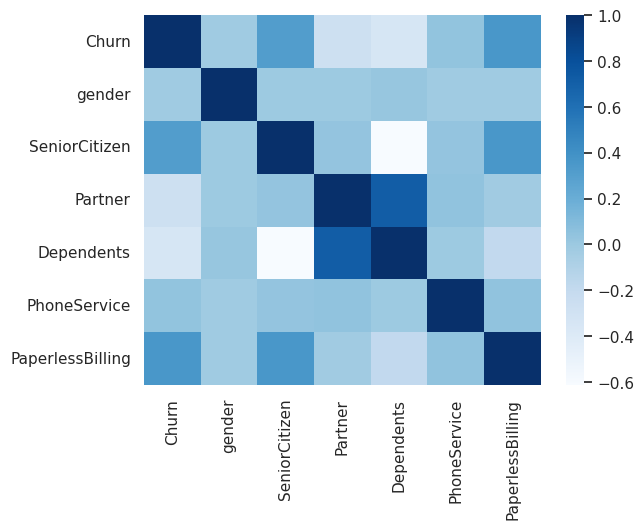

In [28]:
corr = pd.DataFrame(corr_dict, index=binary_data.columns)
sns.heatmap(corr, cmap='Blues')

# 3. Data preprocessing

## 3.1. Encoding categorical variables

Our categorical variables, for many classification models, need to be transformed into numerical variables. By converting categorical variables into numbers, the model can understand and analyze patterns in the data more effectively.

For this transformation, we will use the [One Hot Encoder method.](https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/)

One Hot Encoding is a technique that creates separate binary columns for each category and assigns a binary value (1 or 0) indicating the presence or absence of the category in a particular observation. This avoids the misinterpretation of ordinal relationships between categories, as each category is treated independently.

### Binary variables



In [15]:
binary_features = ['Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

binary_data = df[binary_features].copy()

binary_data.head()

,Churn,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling
0,No,Female,No,Yes,Yes,Yes,Yes
1,No,Male,No,No,No,Yes,No
2,Yes,Male,No,No,No,Yes,Yes
3,Yes,Male,Yes,Yes,No,Yes,Yes
4,Yes,Female,Yes,Yes,No,Yes,Yes


In [16]:
ohe = OneHotEncoder(drop='first')

ohe.fit(binary_data)

OneHotEncoder(drop='first')

In [17]:
encoded_binary_data = ohe.transform(binary_data).toarray()

In [18]:
binary_column_names = ohe.get_feature_names_out()

encoded_binary_df = pd.DataFrame(encoded_binary_data, columns=binary_column_names)

encoded_binary_df.head()

,Churn_No,Churn_Yes,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,PaperlessBilling_Yes
0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
3,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
4,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


### Categorical variables with over two unique values

In [19]:
categorical_features = df.select_dtypes('object').drop(binary_features, axis=1)
categorical_data = categorical_features.drop('customerID', axis=1)

In [20]:
ohe = OneHotEncoder(drop='first')

ohe.fit(categorical_data)

OneHotEncoder(drop='first')

In [21]:
encoded_categorical_data = ohe.transform(categorical_data).toarray()

In [22]:
categorical_column_names = ohe.get_feature_names_out()

encoded_categorical_df = pd.DataFrame(encoded_categorical_data,
                                      columns=categorical_column_names)

encoded_categorical_df.head()

,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Combining the encoded data.

In [23]:
numerical_df = df.drop(categorical_features, axis=1).drop(binary_features, axis=1)
numerical_df.head()

,tenure,MonthlyCharges,TotalCharges,DailyCharges
0,9,65.6,593.30,2.186667
1,9,59.9,542.40,1.996667
2,4,73.9,280.85,2.463333
3,13,98.0,1237.85,3.266667
4,3,83.9,267.40,2.796667


In [39]:
encoded_df = pd.concat([numerical_df.reset_index(drop=True),
                        encoded_categorical_df.astype(int),
                        encoded_binary_df.astype(int)], axis=1).drop('Churn_No', axis=1).rename(columns={'Churn_Yes': 'Churn'})
encoded_df.head()

,tenure,MonthlyCharges,TotalCharges,DailyCharges,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,...,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,PaperlessBilling_Yes
0,9,65.6,593.30,2.186667,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,1,1
1,9,59.9,542.40,1.996667,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
2,4,73.9,280.85,2.463333,0,0,1,0,0,0,...,0,1,0,1,1,0,0,0,1,1
3,13,98.0,1237.85,3.266667,0,0,1,0,0,0,...,0,1,0,1,1,1,1,0,1,1
4,3,83.9,267.40,2.796667,0,0,1,0,0,0,...,0,0,1,1,0,1,1,0,1,1


## 3.2. Dealing with Imbalanced Data

Imbalanced data (or imbalanced classes) refers to situations where different categories or classes of data have significantly different numbers of samples. In our case, there is a substantial disparity between customers who resulted in churn and those who did not.

When data is imbalanced, meaning one class has many more samples than the other, the model may learn in a biased manner, giving more weight to the majority class and neglecting the minority class. This can result in inaccurate predictions and an ineffective model.

It is necessary, therefore, to apply techniques such as resampling, synthetic data generation, or adjusting class weights to balance the influence of different classes in model training, allowing for a fairer and more accurate classification.

### 3.2.1. Using SMOTE

/var/folders/0q/4bxx1cxs6mv6v0vctv66m29m0000gp/T/ipykernel_30469/880300096.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(encoded_df, x='Churn', palette='dark')


<Axes: xlabel='Churn', ylabel='count'>

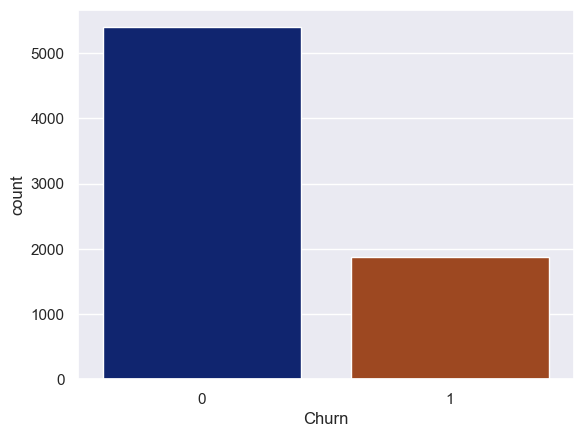

In [41]:
sns.countplot(encoded_df, x='Churn', palette='dark')

We can see that our data has a much larger sampling of customers who did not result in churn (class "No").

To address this, we will use the [Synthetic Minority Over-sampling Technique (SMOTE) method.](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html#r001eabbe5dd7-1)

In summary, SMOTE creates synthetic examples of the minority class, generating new data points based on existing samples.

References:

- [SMOTE for Imbalanced Classification with Python](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)
- [SMOTE: Synthetic Minority Over-sampling Technique](https://arxiv.org/pdf/1106.1813.pdf)

In [43]:
smote = SMOTE(random_state=42)

X = encoded_df.drop('Churn', axis=1)
y = encoded_df['Churn']

X_res, y_res = smote.fit_resample(X, y)

/var/folders/0q/4bxx1cxs6mv6v0vctv66m29m0000gp/T/ipykernel_30469/873960360.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_res, palette='dark')


<Axes: xlabel='Churn', ylabel='count'>

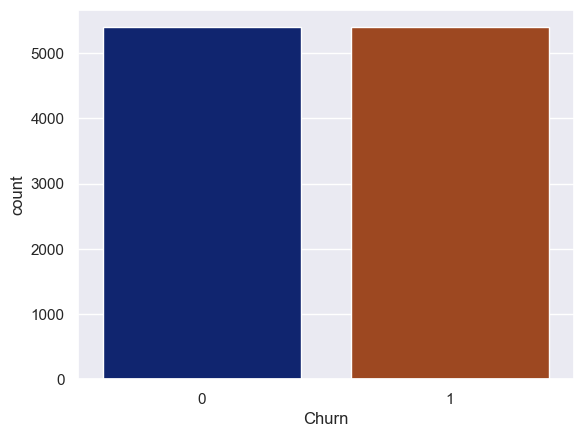

In [44]:
sns.countplot(x=y_res, palette='dark')

Creating a dataframe with balanced data using the X_res and y_res data.

In [33]:
X_res['Churn'] = y_res

balanced_df = X_res.copy()
balanced_df.head()

,tenure,MonthlyCharges,TotalCharges,DailyCharges,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,...,PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,PaperlessBilling_Yes,Churn
0,9,65.6,593.30,2.186667,0,0,0,0,0,0,...,0,1,1,0,0,1,1,1,1,0
1,9,59.9,542.40,1.996667,0,1,0,0,0,0,...,0,1,1,1,0,0,0,1,0,0
2,4,73.9,280.85,2.463333,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,1,1
3,13,98.0,1237.85,3.266667,0,0,1,0,0,0,...,1,0,0,1,1,1,0,1,1,1
4,3,83.9,267.40,2.796667,0,0,1,0,0,0,...,0,1,0,0,1,1,0,1,1,1


### 3.2.1 Using CTGAN

In [111]:
churn_counts = encoded_df['Churn'].value_counts().to_dict()
n_samples = churn_counts[0] - churn_counts[1]

print(n_samples)

encoded_df_churn = encoded_df[encoded_df['Churn'] == 1]

discrete_columns = encoded_df_churn.columns[4:]
ctgan = CTGAN(epochs=10)
ctgan.fit(encoded_df_churn, discrete_columns)

synthetic_data = ctgan.sample(n_samples)
synthetic_data = pd.concat([encoded_df, synthetic_data])

3529


/var/folders/0q/4bxx1cxs6mv6v0vctv66m29m0000gp/T/ipykernel_30469/1204619822.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=synthetic_data['Churn'], palette='dark')


<Axes: xlabel='Churn', ylabel='count'>

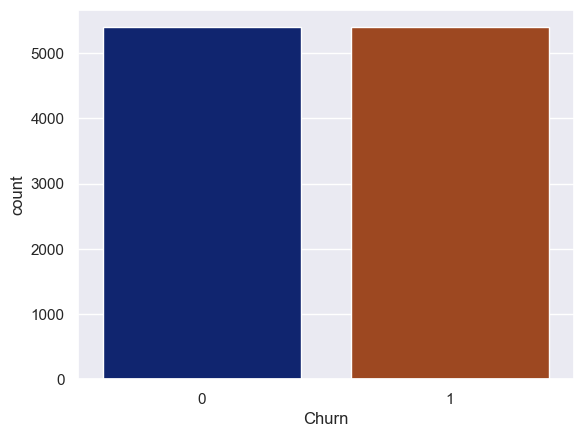

In [78]:
sns.countplot(x=synthetic_data['Churn'], palette='dark')

# 4. Data modeling

## 4.1. Train-test split

Before training our model, we need to split our data into a training set and a test set, with no intersection between them. In other words, data from the test set should not be present in the training set and vice versa. By doing this, when testing the model after training it, we ensure that we are not transferring the bias from the training set to the test data.

In [74]:
X = encoded_df.drop('Churn', axis=1)
y = encoded_df['Churn']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

applying smote and ctgan balancing for train data

In [76]:
smote = SMOTE(random_state=42)
X_train_balanced_smote, y_train_balanced_smote = smote.fit_resample(X_train, y_train)

In [79]:
train_df = pd.concat([X_train, y_train], axis=1)

churn_counts = train_df['Churn'].value_counts().to_dict()
n_samples = churn_counts[0] - churn_counts[1]

print(n_samples)

train_df_churn = train_df[train_df['Churn'] == 1]

discrete_columns = train_df.columns[4:]
ctgan = CTGAN(epochs=10)
ctgan.fit(train_df_churn, discrete_columns)

synthetic_data = ctgan.sample(n_samples)

balanced_train_df = pd.concat([train_df, synthetic_data])
X_train_balanced_ctgan = train_df.drop('Churn', axis=1)
y_train_balanced_ctgan = train_df['Churn']

2412


## 4.2. Traning models

We will train and test 3 types of models:
<br>

**1. Logistic Regression**

[Logistic Regression](https://www.analyticsvidhya.com/blog/2021/08/conceptual-understanding-of-logistic-regression-for-data-science-beginners/) is a supervised learning algorithm used for the classification of categorical values, typically binary, to predict the probability of an event occurring within a set of categories.

Thus, Logistic Regression employs a logistic function to transform the output into values between 0 and 1, representing probabilities, as depicted in the figure below.

Moreover, Logistic Regression only accepts numerical data.

<img src="https://miro.medium.com/v2/resize:fit:460/1*klFuUpBGVAjTfpTak2HhUA.png" alt="drawing" width="400"/>

<br>

**2. Random Forest**

Random Forest is a supervised learning algorithm based on decision trees. Decision trees represent a sequence of decisions to reach a conclusion. Each decision is represented by a node, and the branches from that node represent different choices, where each node indicates a decision based on the value of a sample.

To obtain the result of a Random Forest, we combine the predictions of various individual trees. Each tree is trained on a random subset of the data, and during construction, node splits are made considering a random subset of features.

For making predictions, individual trees vote on the most likely class, and the class with the most votes is considered the final prediction of the Random Forest.

<img src="https://www.researchgate.net/publication/348965642/figure/fig2/AS:986768589463556@1612275373671/Random-Forest-Simplified-2-Extreme-Random-Forest-Then-Limit-Tree-regression-model-is.png" alt="drawing" width="800"/>

Unlike Logistic Regression, Random Forest (as well as tree-based models in general) also accepts categorical variables and can be used for both regression and classification.

<br>

**3. Gradient Boosting**

Gradient Boosting is a supervised learning algorithm that constructs a predictive model by combining multiple simple models, often decision trees.

Unlike Random Forest, where trees are built independently and in parallel, Gradient Boosting works iteratively, where each new tree is trained to correct the residual errors left by the previous models. During training, the algorithm adjusts the model parameters in the direction that minimizes the errors of the previous model.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*OZPOQUKiaVmZOEMm_-8iYA.png" alt="drawing" width="600"/>

In [81]:
lr_smote = LogisticRegression(solver='liblinear')
rfc_smote = RandomForestClassifier()
gbc_smote = GradientBoostingClassifier()

lr_ctgan = LogisticRegression(solver='liblinear')
rfc_ctgan = RandomForestClassifier()
gbc_ctgan = GradientBoostingClassifier()

In [82]:
lr_smote.fit(X_train_balanced_smote, y_train_balanced_smote)
rfc_smote.fit(X_train_balanced_smote, y_train_balanced_smote)
gbc_smote.fit(X_train_balanced_smote, y_train_balanced_smote)

lr_ctgan.fit(X_train_balanced_ctgan, y_train_balanced_ctgan)
rfc_ctgan.fit(X_train_balanced_ctgan, y_train_balanced_ctgan)
gbc_ctgan.fit(X_train_balanced_ctgan, y_train_balanced_ctgan)

GradientBoostingClassifier()

## 4.3. Model evaluation

In [83]:
y_pred_lr_smote = lr_smote.predict(X_test)
y_pred_rfc_smote = rfc_smote.predict(X_test)
y_pred_gbc_smote = gbc_smote.predict(X_test)

y_pred_lr_ctgan = lr_ctgan.predict(X_test)
y_pred_rfc_ctgan = rfc_ctgan.predict(X_test)
y_pred_gbc_ctgan = gbc_ctgan.predict(X_test)

### To evaluate our predictions, we will use Confusion Matrix, Accuracy and Precision.

**1. Confusion Matrix**

([Confusion Matrix](https://medium.com/analytics-vidhya/what-is-a-confusion-matrix-d1c0f8feda5)) is a table that allows visualizing the performance of a classification model.

It shows the number of correct and incorrect predictions made by the model in relation to the actual classes in the dataset. The matrix is organized into four quadrants: True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN).

<img src="https://miro.medium.com/v2/resize:fit:712/1*Z54JgbS4DUwWSknhDCvNTQ.png" alt="drawing" width="600"/>

**2. Accuracy**

[Accuracy score](https://developers.google.com/machine-learning/crash-course/classification/accuracy?hl=pt-br) is a metric that measures the **proportion of correct predictions** made by a model in relation to the total predictions. In other words, it is the model's rate of correct predictions.

It can be obtained directly from the Confusion Matrix, through the formula:

$$
Accuracy = \frac{TP+TN}{TP+TN+FP+FN}
$$

**3. Precision**

[Precision score](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall?hl=pt-br) Precision is a metric that measures the proportion of true positives in relation to the total positive predictions made by the model. In other words, precision indicates the accuracy of the model's positive predictions.

It can be obtained directly from the Confusion Matrix, through the formula:

$$
Precision = \frac{TP}{TP+FP}
$$

#### Confusion Matrix

In [84]:
cm_lr_smote = confusion_matrix(y_pred_lr_smote, y_test)
cm_rfc_smote = confusion_matrix(y_pred_rfc_smote, y_test)
cm_gbc_smote = confusion_matrix(y_pred_gbc_smote, y_test)

cm_lr_ctgan = confusion_matrix(y_pred_lr_ctgan, y_test)
cm_rfc_ctgan = confusion_matrix(y_pred_rfc_ctgan, y_test)
cm_gbc_ctgan = confusion_matrix(y_pred_gbc_ctgan, y_test)

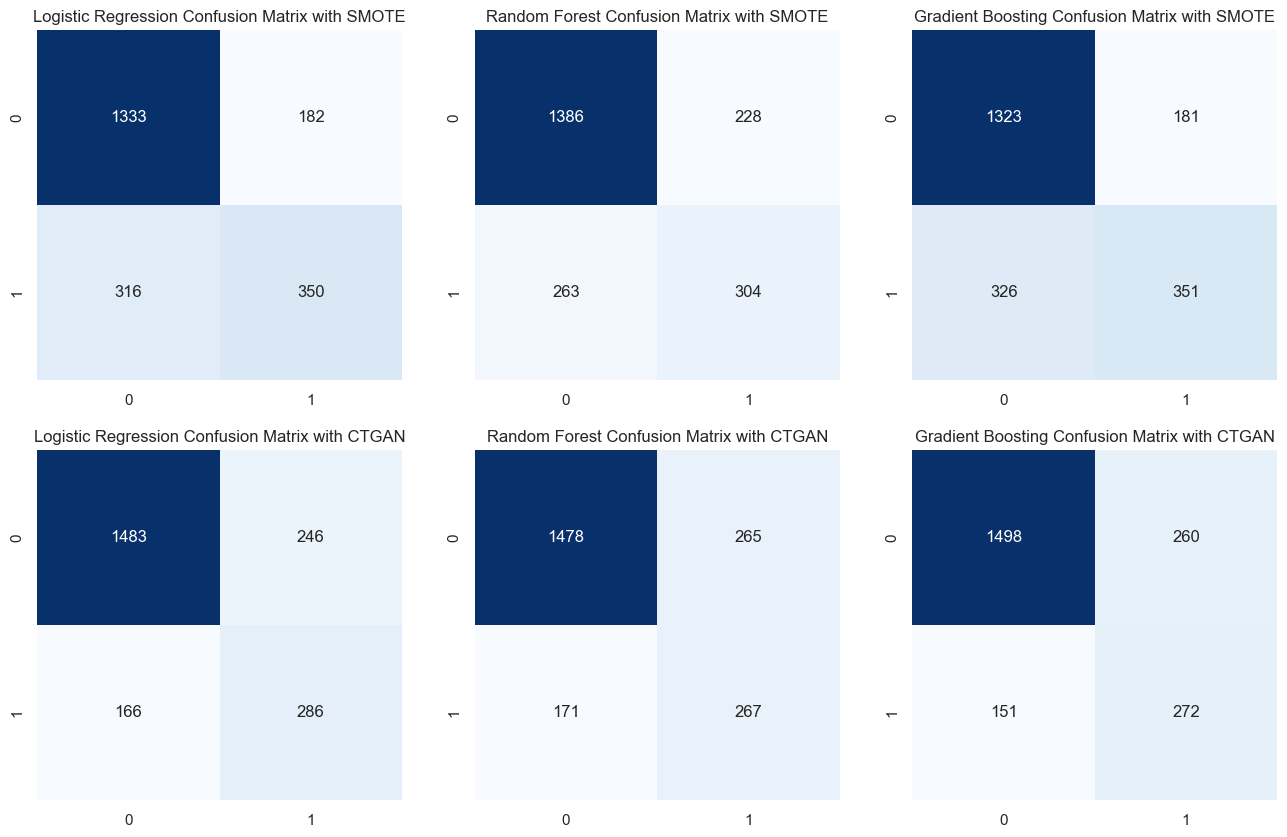

In [110]:
# plot confusion matrix
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))

ax1, ax2, ax3 = axes[0]
ax4, ax5, ax6 = axes[1]

sns.heatmap(cm_lr_smote, annot=True, cmap='Blues', cbar=False, fmt='.0f', ax=ax1)
ax1.set_title('Logistic Regression Confusion Matrix with SMOTE')

sns.heatmap(cm_rfc_smote, annot=True, cmap='Blues', cbar=False, fmt='.0f', ax=ax2)
ax2.set_title('Random Forest Confusion Matrix with SMOTE')

sns.heatmap(cm_gbc_smote, annot=True, cmap='Blues', cbar=False, fmt='.0f', ax=ax3)
ax3.set_title('Gradient Boosting Confusion Matrix with SMOTE')

sns.heatmap(cm_lr_ctgan, annot=True, cmap='Blues', cbar=False, fmt='.0f', ax=ax4)
ax4.set_title('Logistic Regression Confusion Matrix with CTGAN')

sns.heatmap(cm_rfc_ctgan, annot=True, cmap='Blues', cbar=False, fmt='.0f', ax=ax5)
ax5.set_title('Random Forest Confusion Matrix with CTGAN')

sns.heatmap(cm_gbc_ctgan, annot=True, cmap='Blues', cbar=False, fmt='.0f', ax=ax6)
ax6.set_title('Gradient Boosting Confusion Matrix with CTGAN');

#### Accuracy

In [105]:
lr_acc_smote = round(accuracy_score(y_test, y_pred_lr_smote), 3)
rfc_acc_smote = round(accuracy_score(y_test, y_pred_rfc_smote), 3)
gbc_acc_smote = round(accuracy_score(y_test, y_pred_gbc_smote), 3)

print(f"Logistic Regression Accuracy with SMOTE: {lr_acc_smote}")
print(f"Random Forest Accuracy with SMOTE: {rfc_acc_smote}")
print(f"Gradient Boosting Accuracy with SMOTE: {gbc_acc_smote}\n")

lr_acc_ctgan = round(accuracy_score(y_test, y_pred_lr_ctgan), 3)
rfc_acc_ctgan = round(accuracy_score(y_test, y_pred_rfc_ctgan), 3)
gbc_acc_ctgan = round(accuracy_score(y_test, y_pred_gbc_ctgan), 3)

print(f"Logistic Regression Accuracy with CTGAN: {lr_acc_ctgan}")
print(f"Random Forest Accuracy with CTGAN: {rfc_acc_ctgan}")
print(f"Gradient Boosting Accuracy with CTGAN: {gbc_acc_ctgan}")

Logistic Regression Accuracy with SMOTE: 0.772
Random Forest Accuracy with SMOTE: 0.775
Gradient Boosting Accuracy with SMOTE: 0.768

Logistic Regression Accuracy with CTGAN: 0.811
Random Forest Accuracy with CTGAN: 0.8
Gradient Boosting Accuracy with CTGAN: 0.812


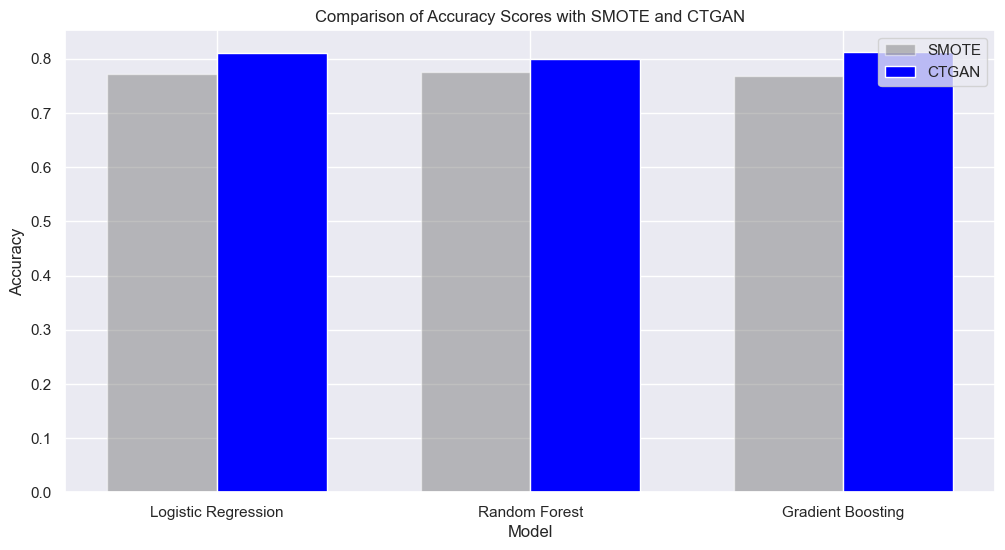

In [106]:
# Data for plotting
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']
acc_smote = [lr_acc_smote, rfc_acc_smote, gbc_acc_smote]
acc_ctgan = [lr_acc_ctgan, rfc_acc_ctgan, gbc_acc_ctgan]

# Plotting the bar chart
x = range(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x, acc_smote, width, alpha=0.5, color='grey', label='SMOTE')
bars2 = ax.bar([p + width for p in x], acc_ctgan, width, color='blue', label='CTGAN')

# Adding labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Accuracy Scores with SMOTE and CTGAN')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(models)
ax.legend()

# Display the plot
plt.show()

#### Precision

In [107]:
lr_acc_smote = round(precision_score(y_test, y_pred_lr_smote), 3)
rfc_acc_smote = round(precision_score(y_test, y_pred_rfc_smote), 3)
gbc_acc_smote = round(precision_score(y_test, y_pred_gbc_smote), 3)

print(f"Logistic Regression Precision with SMOTE: {lr_acc_smote}")
print(f"Random Forest Precision with SMOTE: {rfc_acc_smote}")
print(f"Gradient Boosting Precision with SMOTE: {gbc_acc_smote}\n")

lr_acc_ctgan = round(precision_score(y_test, y_pred_lr_ctgan), 3)
rfc_acc_ctgan = round(precision_score(y_test, y_pred_rfc_ctgan), 3)
gbc_acc_ctgan = round(precision_score(y_test, y_pred_gbc_ctgan), 3)

print(f"Logistic Regression Precision with CTGAN: {lr_acc_ctgan}")
print(f"Random Forest Precision with CTGAN: {rfc_acc_ctgan}")
print(f"Gradient Boosting Precision with CTGAN: {gbc_acc_ctgan}")

Logistic Regression Precision with SMOTE: 0.526
Random Forest Precision with SMOTE: 0.536
Gradient Boosting Precision with SMOTE: 0.518

Logistic Regression Precision with CTGAN: 0.633
Random Forest Precision with CTGAN: 0.61
Gradient Boosting Precision with CTGAN: 0.643


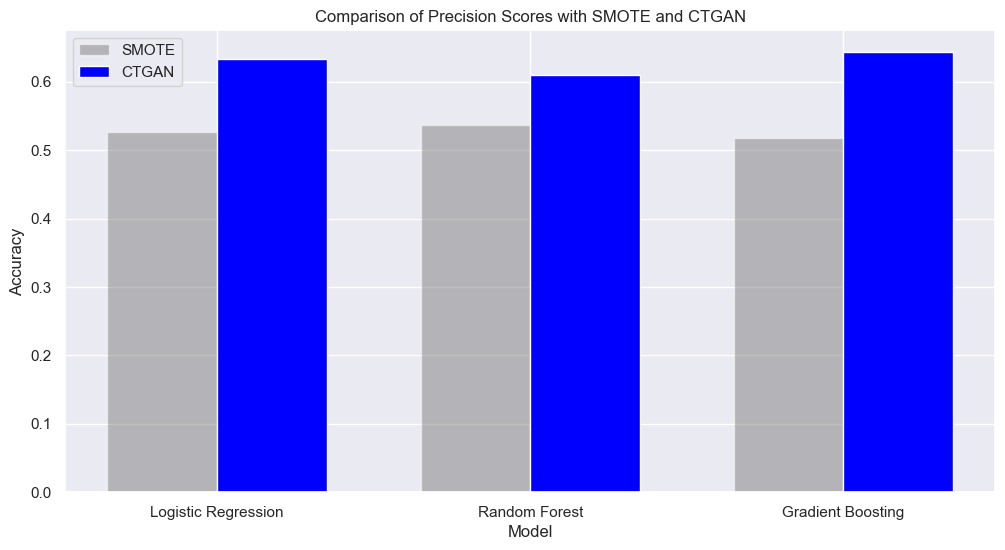

In [108]:
# Data for plotting
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']
acc_smote = [lr_acc_smote, rfc_acc_smote, gbc_acc_smote]
acc_ctgan = [lr_acc_ctgan, rfc_acc_ctgan, gbc_acc_ctgan]

# Plotting the bar chart
x = range(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x, acc_smote, width, alpha=0.5, color='grey', label='SMOTE')
bars2 = ax.bar([p + width for p in x], acc_ctgan, width, color='blue', label='CTGAN')

# Adding labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Precision Scores with SMOTE and CTGAN')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(models)
ax.legend()

# Display the plot
plt.show()

### Choosing model:

Based on the evaluation metrics, we can choose Random Forest as our main model, as it achieved better performance in our evaluation methods.

### Feature importances

Tree-based methods allow us to assess the variables with the greatest impact (importance) on the results.

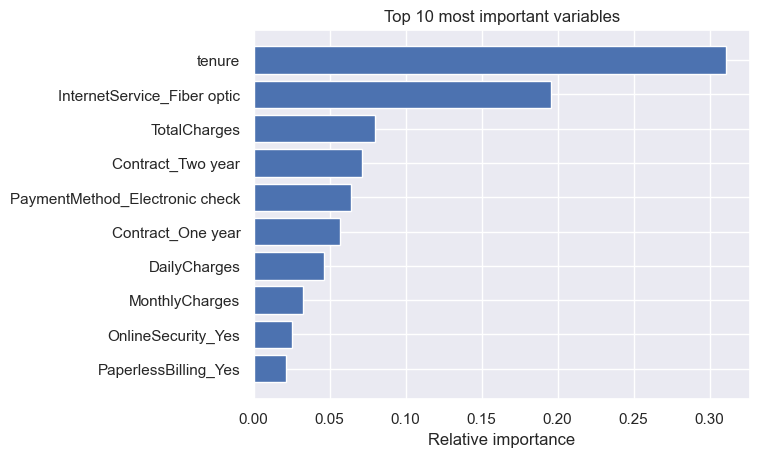

In [56]:
features = X_train.columns
importances = gbc.feature_importances_
indices = np.argsort(importances)

num_features = 10

plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative importance')
plt.title('Top 10 most important variables')
plt.show()